Наша практика будет основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа).

[СКАЧАТЬ ДАННЫЕ](https://lms-cdn.skillfactory.ru/assets/courseware/v1/9f2add5bca59f8c4df927432d605fff3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/_train_sem09__1_.zip)

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776). 

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

- Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- Остальные столбцы D1-D1776 представляют собой молекулярные **дескрипторы** — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

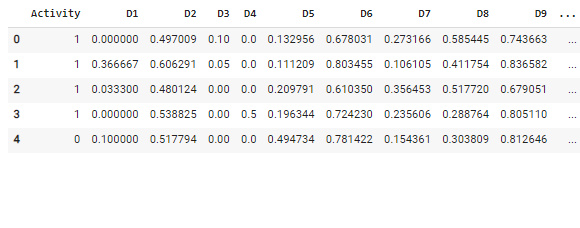

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: **логистическую регрессию** и **случайный лес**. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать **все четыре метода** (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

In [2]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='Activity', ylabel='count'>

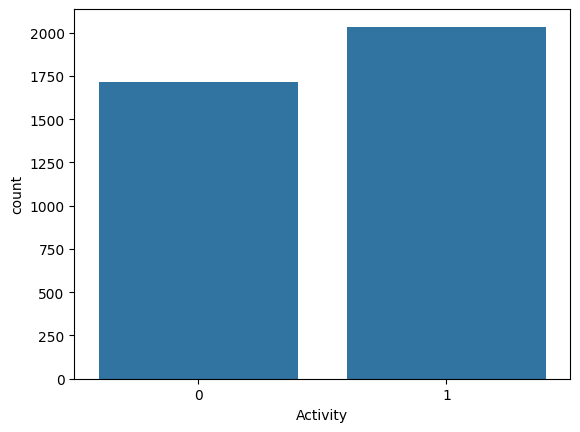

In [3]:
sns.countplot(data=data, x='Activity')

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### 1.) Логистическая регрессия

In [6]:
# Создаем и обучаем логистическую регрессию без подбора гиперпараметров
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


In [7]:
# GridSearchCV

param_grid = [
              {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_lg = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=8000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_lg.fit(X_train, y_train) 

y_test_pred = grid_search_lg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lg.best_params_))


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users

CPU times: total: 5.39 s
Wall time: 8min 13s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Удалось улучшить целевую метрику с 0.78 до 0.79

In [8]:
# RandomizedSearchCV

param_grid = {'penalty': ['l2', 'none'],
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search_lg = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=8000), 
    param_distributions=param_grid, 
    cv=5, 
    n_iter = 30, 
    n_jobs = -1
)  
%time random_search_lg.fit(X_train, y_train) 
y_test_pred = random_search_lg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lg.best_params_))

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\User

CPU times: total: 5.42 s
Wall time: 1min 16s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(0.12)}


Целевая метрика не ухудшилась, при этом время выполнения сильно сократилось.

In [9]:
# Hyperopt

space={'penalty': hp.choice('penalty', ['l2', None]),
       'solver' : hp.choice('solver', ['saga', 'sag', 'lbfgs'])
      } 


In [10]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'penalty': params['penalty'], 
              'solver': params['solver']
              }
  
    model = linear_model.LogisticRegression(**params, random_state=42, max_iter=8000)

    # обучаем модель можно с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [11]:
# начинаем подбор гиперпараметров
trials = Trials()

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [19:17<00:00, 57.88s/trial, best loss: -0.7703474211849926]  
Наилучшие значения гиперпараметров {'penalty': np.int64(0), 'solver': np.int64(2)}


In [12]:
# рассчитаем f1_score для тестовой выборки

model = linear_model.LogisticRegression(penalty='l2', solver='sag', random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78


In [13]:
# Optuna

def optuna_lr(trial):
  
  penalty = trial.suggest_categorical('penalty', ['l2', None])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_float('C', 0.01, 1)
  
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=42,
                                          max_iter=8000)

  # обучаем модель можно с помощью кросс-валидации
  # применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [14]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=30)

[I 2025-05-30 15:48:18,392] A new study created in memory with name: LogisticRegression
[I 2025-05-30 15:48:28,815] Trial 0 finished with value: 0.7021211453368786 and parameters: {'penalty': None, 'solver': 'lbfgs', 'C': 0.738761478105978}. Best is trial 0 with value: 0.7021211453368786.
[I 2025-05-30 15:52:23,343] Trial 1 finished with value: 0.7380334294277231 and parameters: {'penalty': None, 'solver': 'sag', 'C': 0.8012423975326803}. Best is trial 1 with value: 0.7380334294277231.
[I 2025-05-30 15:52:41,763] Trial 2 finished with value: 0.780405231130305 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.2021460857187019}. Best is trial 2 with value: 0.780405231130305.
[I 2025-05-30 15:52:59,182] Trial 3 finished with value: 0.7702029110146973 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.6887487146082082}. Best is trial 2 with value: 0.780405231130305.
[I 2025-05-30 15:53:09,333] Trial 4 finished with value: 0.7021211453368786 and parameters: {'penalty': None, 

CPU times: total: 1.81 s
Wall time: 16min 51s


In [15]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 0.029355021481588174}
f1_score на обучающем наборе: 0.78


In [16]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


Удалось улучшить целевую метрику до 0.80

### 2.) Случайный лес

In [17]:
# Создаем и обучаем случайный лес без подбора гиперпараметров
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


In [18]:
# GridSearchCV

param_grid = {'n_estimators': list(range(100, 300, 30)),
              'min_samples_leaf': list(np.linspace(2, 10, 1, dtype=int)),
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 4.47 s
Wall time: 57.5 s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'max_depth': np.int64(35), 'min_samples_leaf': np.int64(2), 'n_estimators': 280}


Целевая метрика улучшена до 0.83

In [19]:
# RandomizedSearchCV

param_grid = {'n_estimators': list(range(100, 300, 30)),
              'min_samples_leaf': list(np.linspace(2, 10, 1, dtype=int)),
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 4.36 s
Wall time: 37 s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 280, 'min_samples_leaf': np.int64(2), 'max_depth': np.int64(35)}


Целевая метрика улучшена до 0.83. Время, затраченное на рассчеты, меньше, чем GridSearchCV

In [20]:
# Hyperopt

space={'n_estimators': hp.quniform('n_estimators', 100, 300, 30),
       'max_depth' : hp.quniform('max_depth', 20, 40, 10),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [21]:
random_state = 42

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    # обучаем модель с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return -score

In [22]:
%%time
# подбор гиперпараметров

trials = Trials()

best=fmin(hyperopt_rf,
          space=space,
          algo=tpe.suggest,
          max_evals=20,
          trials=trials,
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:48<00:00,  2.41s/trial, best loss: -0.810782508851845]
Наилучшие значения гиперпараметров {'max_depth': np.float64(30.0), 'min_samples_leaf': np.float64(3.0), 'n_estimators': np.float64(240.0)}
CPU times: total: 734 ms
Wall time: 48.2 s


In [23]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.83


Целевая метрика улучшена до 0.83. Время, затраченное на рассчеты, меньше чем у GridSearchCV

In [24]:
# Optuna

def optuna_rf(trial):
  
  n_estimators = trial.suggest_int('n_estimators', 100, 310, 30)
  max_depth = trial.suggest_int('max_depth', 20, 40, 10)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель с помощью кросс-валидации
  # применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [25]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-05-30 16:07:43,324] A new study created in memory with name: RandomForestClassifier
C:\Users\user\AppData\Local\Temp\ipykernel_15252\2514203226.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 100, 310, 30)
C:\Users\user\AppData\Local\Temp\ipykernel_15252\2514203226.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 20, 40, 10)
C:\Users\user\AppData\Local\Temp\ipykernel_15252\2514203226.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
[I 2025-05-30 16:07:44,805] Trial 0 finished with value: 0.7993498364504066 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf':

CPU times: total: 922 ms
Wall time: 1min 1s


In [26]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 220, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.81


In [27]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82


Целевая метрика улучшена до 0.82. Время, затраченное на рассчеты, меньше чем GridSeachCV